# 3D Grounding with Qwen3-VL (Together AI)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/togethercomputer/together-cookbook/blob/main/Multimodal/Vision/3D_Grounding.ipynb)


## Introduction

In this notebook, we'll explore Qwen3-VL's 3D spatial understanding capabilities using Together AI's API. We'll cover:

1. Detecting objects with 3D bounding boxes
2. Using camera parameters for accurate projections
3. Multi-object 3D localization

3D bounding boxes are represented as: `[x_center, y_center, z_center, x_size, y_size, z_size, roll, pitch, yaw]`


### Install required libraries


In [ ]:
!pip install -qU together pydantic pillow numpy matplotlib opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 8.9 MB/s eta 0:00:00a 0:00:01m


In [2]:
import os
import json
import math
import random
import base64
import cv2
import numpy as np
import matplotlib.pyplot as plt
import together
from typing import Optional
from pydantic import BaseModel, Field
from PIL import Image

# Together AI Configuration
client = together.Together()

MODEL_ID = "Qwen/Qwen3-VL-32B-Instruct"

print(f"Using model: {MODEL_ID}")
print(f"API Key configured: {bool(os.environ.get('TOGETHER_API_KEY'))}")


Using model: Qwen/Qwen3-VL-32B-Instruct
API Key configured: True


In [3]:
# Pydantic schemas for structured JSON output
class BoundingBox3D(BaseModel):
    """A single 3D bounding box detection."""
    bbox_3d: list[float] = Field(description="3D bounding box as [x_center, y_center, z_center, x_size, y_size, z_size, roll, pitch, yaw]")
    label: str = Field(description="Object category label")

class BoundingBox3DList(BaseModel):
    """List of 3D bounding box detections."""
    detections: list[BoundingBox3D] = Field(description="List of detected objects with 3D bounding boxes")

def encode_image(image_path):
    """Encode image to base64."""
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

def get_mime_type(image_path):
    """Get MIME type from file extension."""
    ext = image_path.split(".")[-1].lower()
    return "jpeg" if ext in ["jpg", "jpeg"] else ext

def inference_with_json_schema(image_path, prompt, schema: type[BaseModel], max_tokens=4096):
    """Run inference with Together AI API using JSON mode.
    
    Args:
        image_path: Path to the image file
        prompt: Text prompt for the model
        schema: Pydantic model class defining the expected output structure
        max_tokens: Maximum tokens to generate
    
    Returns:
        Parsed JSON dict matching the schema
    """
    base64_image = encode_image(image_path)
    mime_type = get_mime_type(image_path)
    
    response = client.chat.completions.create(
        model=MODEL_ID,
        messages=[
            {
                "role": "system",
                "content": f"Analyze the image and respond only in JSON following this schema: {json.dumps(schema.model_json_schema())}",
            },
            {
                "role": "user",
                "content": [
                    {"type": "image_url", "image_url": {"url": f"data:image/{mime_type};base64,{base64_image}"}},
                    {"type": "text", "text": prompt},
                ],
            }
        ],
        max_tokens=max_tokens,
        response_format={
            "type": "json_schema",
            "schema": schema.model_json_schema(),
        },
    )
    
    return json.loads(response.choices[0].message.content)

def convert_3dbbox(point, cam_params):
    """Convert 3D bounding box to 2D image coordinates."""
    x, y, z, x_size, y_size, z_size, pitch, yaw, roll = point
    hx, hy, hz = x_size / 2, y_size / 2, z_size / 2
    local_corners = [
        [hx, hy, hz], [hx, hy, -hz], [hx, -hy, hz], [hx, -hy, -hz],
        [-hx, hy, hz], [-hx, hy, -hz], [-hx, -hy, hz], [-hx, -hy, -hz]
    ]

    def rotate_xyz(pt, _pitch, _yaw, _roll):
        x0, y0, z0 = pt
        x1, y1 = x0, y0 * math.cos(_pitch) - z0 * math.sin(_pitch)
        z1 = y0 * math.sin(_pitch) + z0 * math.cos(_pitch)
        x2 = x1 * math.cos(_yaw) + z1 * math.sin(_yaw)
        y2, z2 = y1, -x1 * math.sin(_yaw) + z1 * math.cos(_yaw)
        x3 = x2 * math.cos(_roll) - y2 * math.sin(_roll)
        y3, z3 = x2 * math.sin(_roll) + y2 * math.cos(_roll), z2
        return [x3, y3, z3]
    
    img_corners = []
    for corner in local_corners:
        rotated = rotate_xyz(corner, np.deg2rad(pitch), np.deg2rad(yaw), np.deg2rad(roll))
        X, Y, Z = rotated[0] + x, rotated[1] + y, rotated[2] + z
        if Z > 0:
            x_2d = cam_params['fx'] * (X / Z) + cam_params['cx']
            y_2d = cam_params['fy'] * (Y / Z) + cam_params['cy']
            img_corners.append([x_2d, y_2d])
    return img_corners

def draw_3dbboxes(image_path, cam_params, bbox_3d_list):
    """Draw multiple 3D bounding boxes on the image."""
    annotated_image = cv2.imread(image_path)
    if annotated_image is None:
        print(f"Error reading image: {image_path}")
        return None

    edges = [[0,1], [2,3], [4,5], [6,7], [0,2], [1,3], [4,6], [5,7], [0,4], [1,5], [2,6], [3,7]]
    
    for bbox_data in bbox_3d_list:
        bbox_3d = bbox_data['bbox_3d'] if isinstance(bbox_data, dict) and 'bbox_3d' in bbox_data else bbox_data
        bbox_3d = list(bbox_3d)
        bbox_3d[-3:] = [_x * 180 for _x in bbox_3d[-3:]]
        bbox_2d = convert_3dbbox(bbox_3d, cam_params)

        if len(bbox_2d) >= 8:
            box_color = [random.randint(0, 255) for _ in range(3)]
            for start, end in edges:
                try:
                    pt1 = tuple([int(_pt) for _pt in bbox_2d[start]])
                    pt2 = tuple([int(_pt) for _pt in bbox_2d[end]])
                    cv2.line(annotated_image, pt1, pt2, box_color, 2)
                except:
                    continue

    annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(annotated_image_rgb)
    ax.axis('off')
    return fig

def load_camera_params(image_name):
    """Load camera parameters from JSON file."""
    try:
        with open('../assets/spatial_understanding/cam_infos.json', 'r') as f:
            cam_infos = json.load(f)
        return cam_infos.get(image_name, None)
    except:
        return None

def generate_camera_params(image_path, fov=60):
    """Generate camera parameters if not available."""
    image = Image.open(image_path)
    w, h = image.size
    fx = round(w / (2 * np.tan(np.deg2rad(fov) / 2)), 2)
    fy = round(h / (2 * np.tan(np.deg2rad(fov) / 2)), 2)
    cx, cy = round(w / 2, 2), round(h / 2, 2)
    return {'fx': fx, 'fy': fy, 'cx': cx, 'cy': cy}


## 1. Detect Objects of Specific Categories


{
  "detections": [
    {
      "bbox_3d": [
        2.62,
        0.6,
        12.2,
        4.06,
        1.59,
        1.75,
        0.89,
        0.47,
        0.89
      ],
      "label": "car"
    },
    {
      "bbox_3d": [
        2.7,
        0.65,
        5.43,
        4.23,
        1.66,
        1.78,
        0.89,
        0.47,
        0.89
      ],
      "label": "car"
    }
  ]
}


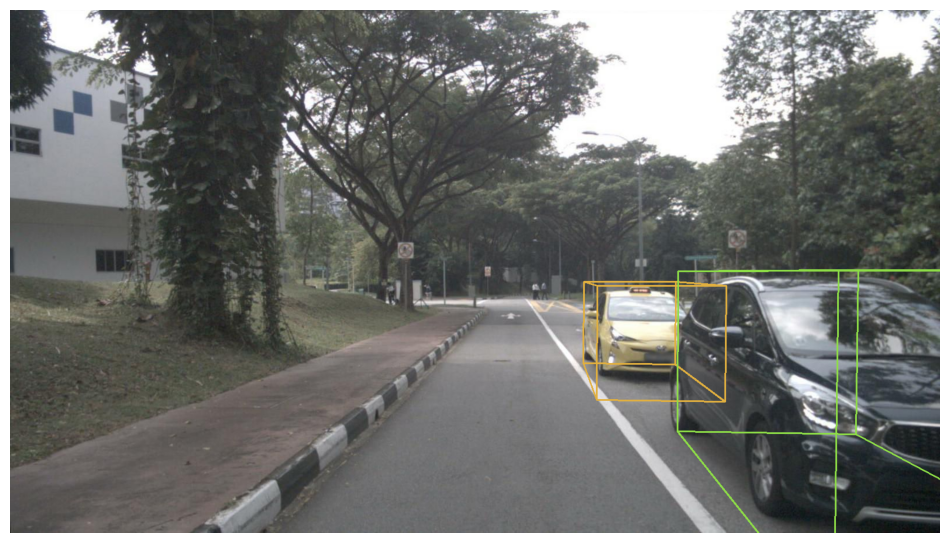

In [4]:
# Example 1: Detect all cars in autonomous driving scene
image_path = "../assets/spatial_understanding/autonomous_driving.jpg"
prompt = "Find all cars in this image. For each car, provide its 3D bounding box in the detections array."

cam_params = load_camera_params("autonomous_driving.jpg")
if cam_params is None:
    cam_params = generate_camera_params(image_path)
    print("Using generated camera params:", cam_params)

result = inference_with_json_schema(image_path, prompt, BoundingBox3DList)
print(json.dumps(result, indent=2))

fig = draw_3dbboxes(image_path, cam_params, result["detections"])
if fig:
    plt.show()


## 2. Detect a Specific Object Using Descriptions


{
  "detections": [
    {
      "bbox_3d": [
        -0.45,
        0.07,
        2.99,
        0.77,
        1.0,
        0.76,
        0.08,
        0.27,
        0.08
      ],
      "label": "black chair"
    }
  ]
}


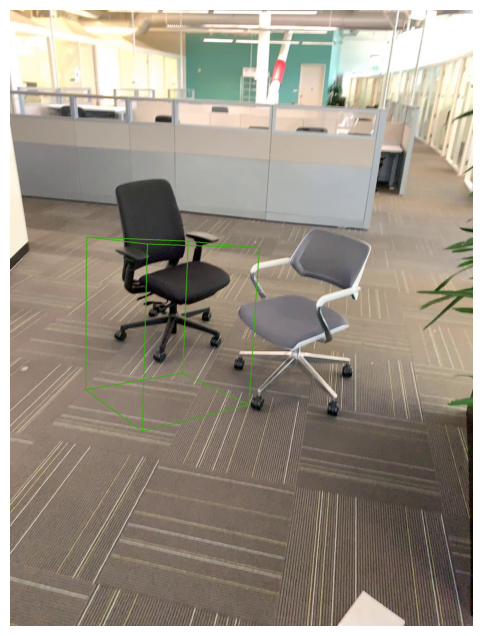

In [8]:
# Example 2: Detect a specific object using descriptions
image_path = "../assets/spatial_understanding/office.jpg"
prompt = "Locate the black chair in the image and provide its 3D bounding box in the detections array."

cam_params = load_camera_params("office.jpg")
if cam_params is None:
    cam_params = generate_camera_params(image_path)

result = inference_with_json_schema(image_path, prompt, BoundingBox3DList)
print(json.dumps(result, indent=2))

fig = draw_3dbboxes(image_path, cam_params, result["detections"])
if fig:
    plt.show()


## 3. Detect Multiple Objects


{
  "detections": [
    {
      "bbox_3d": [
        0.38,
        0.3,
        2.66,
        0.92,
        0.76,
        1.87,
        0.95,
        0.14,
        0.98
      ],
      "label": "tables"
    },
    {
      "bbox_3d": [
        0.2,
        0.39,
        2.1,
        0.51,
        0.75,
        0.45,
        0.05,
        -0.14,
        -0.02
      ],
      "label": "chairs"
    },
    {
      "bbox_3d": [
        -0.04,
        0.23,
        2.63,
        0.52,
        0.75,
        0.42,
        0.05,
        -0.14,
        -0.02
      ],
      "label": "chairs"
    },
    {
      "bbox_3d": [
        -1.1,
        -0.19,
        3.8,
        0.8,
        0.81,
        2.14,
        0.1,
        0.35,
        0.09
      ],
      "label": "sofas"
    }
  ]
}


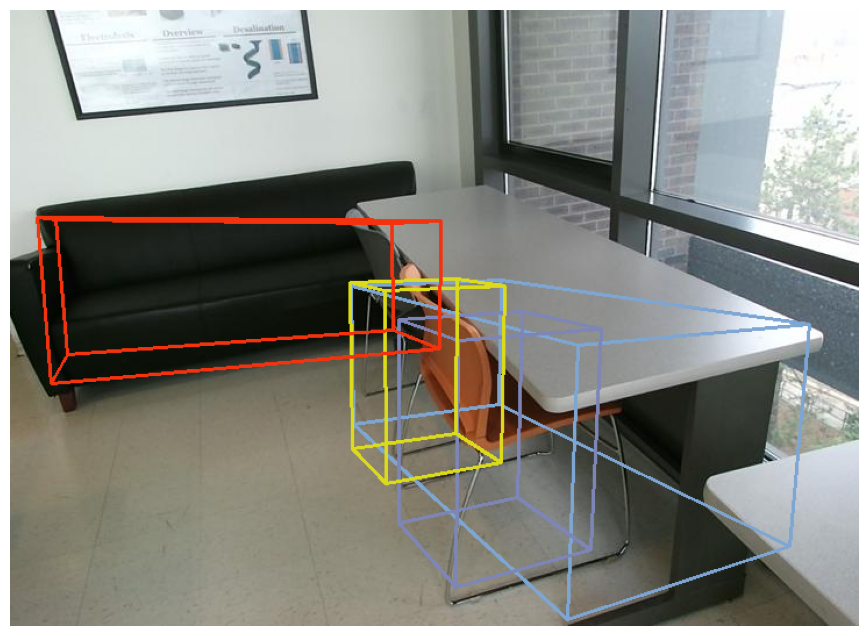

In [9]:
# Example 3: Detect multiple objects simultaneously
image_path = "../assets/spatial_understanding/lounge.jpg"
prompt = "Locate all tables, chairs, and sofas in the image and provide their 3D bounding boxes in the detections array."

cam_params = load_camera_params("lounge.jpg")
if cam_params is None:
    cam_params = generate_camera_params(image_path)

result = inference_with_json_schema(image_path, prompt, BoundingBox3DList)
print(json.dumps(result, indent=2))

fig = draw_3dbboxes(image_path, cam_params, result["detections"])
if fig:
    plt.show()


## 4. Using Custom Camera Parameters

When you don't have access to the original camera intrinsic parameters, you can generate parameters with a field of view of 60°.


Generated camera params: {'fx': np.float64(554.26), 'fy': np.float64(415.69), 'cx': 320.0, 'cy': 240.0}
{
  "detections": [
    {
      "bbox_3d": [
        0.04,
        -0.01,
        0.68,
        0.08,
        0.24,
        0.08,
        0.8,
        0.37,
        0.82
      ],
      "label": "bottle"
    }
  ]
}


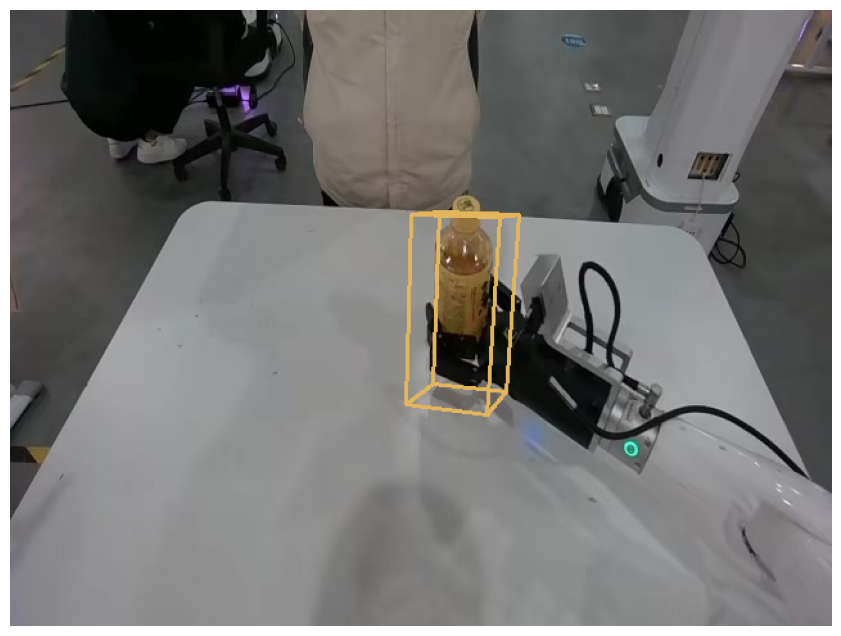

In [7]:
# Example 4: Using custom camera parameters
image_path = "../assets/spatial_understanding/manipulation.jpg"
prompt = "Detect the bottle in the image and provide its 3D bounding box in the detections array."

# Generate camera parameters with 60° FOV
cam_params = generate_camera_params(image_path, fov=60)
print("Generated camera params:", cam_params)

result = inference_with_json_schema(image_path, prompt, BoundingBox3DList)
print(json.dumps(result, indent=2))

fig = draw_3dbboxes(image_path, cam_params, result["detections"])
if fig:
    plt.show()
